In [1]:
!python -V

Python 3.11.8


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
import mlflow
import mlflow.xgboost

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Airline-Flight-Prices-India")

<Experiment: artifact_location='/Users/l.g./Documents/Repo/ml_ops_retail_model_pipeline/model_tracking/mlruns/1', creation_time=1720060282276, experiment_id='1', last_update_time=1720060282276, lifecycle_stage='active', name='Airline-Flight-Prices-India', tags={}>

In [4]:
df = pd.read_csv('../retail_data/flight_dataset.csv')

In [5]:
df.head(n=5)

,Airline,Source,Destination,Total_Stops,Price,Date,Month,Year,Dep_hours,Dep_min,Arrival_hours,Arrival_min,Duration_hours,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,2019,16,50,21,35,4,45


In [6]:
df.shape

(10683, 14)

In [7]:
df['SO_DE'] = df['Source'] + '_' + df['Destination']

In [8]:
categorical = ['SO_DE'] #['Source', 'Destination']
numerical = ['Duration_hours']

In [9]:
df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [11]:
dv = DictVectorizer()
X = dv.fit_transform(train_dicts)

In [12]:
target = 'Price'
y = df[target].values

In [13]:
#y_train

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training, 20% validation

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
y_pred = lr.predict(X_val)

/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_92825/1351390157.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_92825/1351390157.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

<Axes: ylabel='Density'>

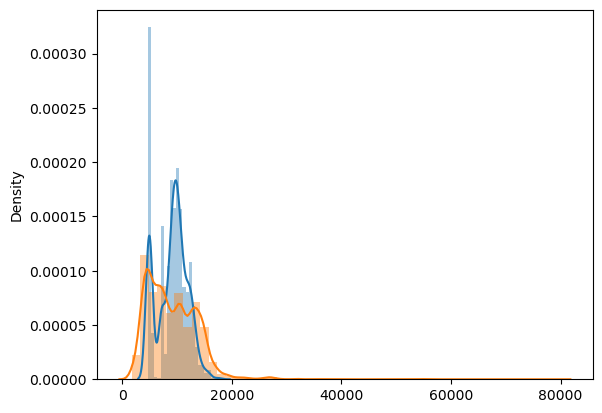

In [17]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

In [18]:
mean_squared_error(y_val, y_pred, squared=False)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3697.485935178474

In [19]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error on validation set: {rmse}")

Root Mean Squared Error on validation set: 3697.485935178474


In [20]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Lamar")

    mlflow.log_param("training-data-path", "../retail_data/flight_dataset.csv")
    mlflow.log_param("validation-data-path", "../retail_data/flight_dataset.csv")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)
    
    y_pred = ls.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg_lasso.bin", artifact_path="models_pickle/")

MlflowException: Invalid artifact path: 'models_pickle/'. Names may be treated as files in certain cases, and must not resolve to other names when treated as such. This name would resolve to 'models_pickle'

In [ ]:
with open('../models/lin_lasso_reg.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

In [22]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}



In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lamdba', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3), 
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

[0]	validation-rmse:4324.44532                                                                                                                               
[1]	validation-rmse:4103.76187                                                                                                                               
[2]	validation-rmse:3929.14014                                                                                                                               
[3]	validation-rmse:3792.66251                                                                                                                               
[4]	validation-rmse:3686.24233                                                                                                                               
[5]	validation-rmse:3604.61052                                                                                                                               
[6]	validation-rmse:3542.19464                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:3358.89822                                                                                                                              
[20]	validation-rmse:3358.12325                                                                                                                              
[21]	validation-rmse:3357.59771                                                                                                                              
[22]	validation-rmse:3357.52846                                                                                                                              
[23]	validation-rmse:3357.35342                                                                                                                              
[24]	validation-rmse:3357.45808                                                                                                                              
[25]	validation-rmse:3357.50615                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[37]	validation-rmse:3358.87747                                                                                                                              
[38]	validation-rmse:3358.99272                                                                                                                              
[39]	validation-rmse:3359.19668                                                                                                                              
[40]	validation-rmse:3358.02659                                                                                                                              
[41]	validation-rmse:3359.34868                                                                                                                              
[42]	validation-rmse:3358.70020                                                                                                                              
[43]	validation-rmse:3359.10372                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3360.11113                                                                                                                              
[39]	validation-rmse:3360.22023                                                                                                                              
[40]	validation-rmse:3360.14834                                                                                                                              
[41]	validation-rmse:3360.24733                                                                                                                              
[42]	validation-rmse:3360.22962                                                                                                                              
[43]	validation-rmse:3360.19531                                                                                                                              
[44]	validation-rmse:3360.28254                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3356.30664                                                                                                                              
[41]	validation-rmse:3357.13602                                                                                                                              
[42]	validation-rmse:3357.12275                                                                                                                              
[43]	validation-rmse:3356.47518                                                                                                                              
[44]	validation-rmse:3357.17858                                                                                                                              
[45]	validation-rmse:3356.30306                                                                                                                              
[46]	validation-rmse:3356.89415                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:17] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3358.36232                                                                                                                              
[41]	validation-rmse:3358.11628                                                                                                                              
[42]	validation-rmse:3358.06001                                                                                                                              
[43]	validation-rmse:3357.92932                                                                                                                              
[44]	validation-rmse:3357.84092                                                                                                                              
[45]	validation-rmse:3357.88468                                                                                                                              
[46]	validation-rmse:3357.85452                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:17] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[72]	validation-rmse:3345.87685                                                                                                                              
[73]	validation-rmse:3345.89008                                                                                                                              
[74]	validation-rmse:3345.92845                                                                                                                              
[75]	validation-rmse:3345.95755                                                                                                                              
[76]	validation-rmse:3346.00040                                                                                                                              
[77]	validation-rmse:3346.01160                                                                                                                              
[78]	validation-rmse:3346.10906                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:17] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[42]	validation-rmse:3359.44628                                                                                                                              
[43]	validation-rmse:3359.52071                                                                                                                              
[44]	validation-rmse:3359.59098                                                                                                                              
[45]	validation-rmse:3359.65573                                                                                                                              
[46]	validation-rmse:3359.71577                                                                                                                              
[47]	validation-rmse:3359.77143                                                                                                                              
[48]	validation-rmse:3359.82239                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[37]	validation-rmse:3361.70829                                                                                                                              
[38]	validation-rmse:3361.66732                                                                                                                              
[39]	validation-rmse:3361.75588                                                                                                                              
[40]	validation-rmse:3361.73538                                                                                                                              
[41]	validation-rmse:3361.78804                                                                                                                              
[42]	validation-rmse:3361.82156                                                                                                                              
[43]	validation-rmse:3361.87681                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3358.65551                                                                                                                              
[42]	validation-rmse:3358.66824                                                                                                                              
[43]	validation-rmse:3358.69663                                                                                                                              
[44]	validation-rmse:3358.73805                                                                                                                              
[45]	validation-rmse:3358.79147                                                                                                                              
[46]	validation-rmse:3358.84940                                                                                                                              
[47]	validation-rmse:3358.91214                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:3354.82068                                                                                                                              
[37]	validation-rmse:3354.63201                                                                                                                              
[38]	validation-rmse:3355.33025                                                                                                                              
[39]	validation-rmse:3355.73782                                                                                                                              
[40]	validation-rmse:3355.47409                                                                                                                              
[41]	validation-rmse:3355.75293                                                                                                                              
[42]	validation-rmse:3355.82206                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:3356.17997                                                                                                                              
[44]	validation-rmse:3356.15602                                                                                                                              
[45]	validation-rmse:3356.18135                                                                                                                              
[46]	validation-rmse:3356.38928                                                                                                                              
[47]	validation-rmse:3356.27530                                                                                                                              
[48]	validation-rmse:3356.32409                                                                                                                              
[49]	validation-rmse:3356.55070                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[35]	validation-rmse:3360.28052                                                                                                                              
[36]	validation-rmse:3360.28883                                                                                                                              
[37]	validation-rmse:3360.29559                                                                                                                              
[38]	validation-rmse:3360.30103                                                                                                                              
[39]	validation-rmse:3360.30542                                                                                                                              
[40]	validation-rmse:3360.30893                                                                                                                              
[41]	validation-rmse:3360.31182                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3362.41423                                                                                                                              
[50]	validation-rmse:3362.41736                                                                                                                              
[51]	validation-rmse:3362.41661                                                                                                                              
[52]	validation-rmse:3362.40983                                                                                                                              
[53]	validation-rmse:3362.41640                                                                                                                              
[54]	validation-rmse:3362.42571                                                                                                                              
[0]	validation-rmse:3772.28532                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[52]	validation-rmse:3360.32346                                                                                                                              
[53]	validation-rmse:3360.32346                                                                                                                              
[54]	validation-rmse:3360.32346                                                                                                                              
[0]	validation-rmse:4415.86296                                                                                                                               
[1]	validation-rmse:4255.45074                                                                                                                               
[2]	validation-rmse:4116.93688                                                                                                                               
[3]	validation-rmse:3997.86786                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3358.64850                                                                                                                              
[51]	validation-rmse:3358.74625                                                                                                                              
[52]	validation-rmse:3358.85167                                                                                                                              
[53]	validation-rmse:3358.95002                                                                                                                              
[54]	validation-rmse:3359.03150                                                                                                                              
[55]	validation-rmse:3359.12710                                                                                                                              
[56]	validation-rmse:3359.21467                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3359.71412                                                                                                                              
[48]	validation-rmse:3359.37077                                                                                                                              
[49]	validation-rmse:3359.58957                                                                                                                              
[50]	validation-rmse:3359.64616                                                                                                                              
[51]	validation-rmse:3359.88232                                                                                                                              
[52]	validation-rmse:3359.81609                                                                                                                              
[53]	validation-rmse:3360.16720                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3362.47019                                                                                                                              
[50]	validation-rmse:3362.46991                                                                                                                              
[51]	validation-rmse:3362.47020                                                                                                                              
[0]	validation-rmse:4228.20488                                                                                                                               
[1]	validation-rmse:3958.30910                                                                                                                               
[2]	validation-rmse:3766.57885                                                                                                                               
[3]	validation-rmse:3632.70981                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3360.30743                                                                                                                              
[45]	validation-rmse:3360.31034                                                                                                                              
[46]	validation-rmse:3360.31240                                                                                                                              
[47]	validation-rmse:3360.31442                                                                                                                              
[48]	validation-rmse:3360.31601                                                                                                                              
[49]	validation-rmse:3360.31726                                                                                                                              
[50]	validation-rmse:3360.31824                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:3360.46732                                                                                                                              
[49]	validation-rmse:3360.94048                                                                                                                              
[50]	validation-rmse:3361.19717                                                                                                                              
[51]	validation-rmse:3361.48151                                                                                                                              
[52]	validation-rmse:3361.92556                                                                                                                              
[53]	validation-rmse:3362.32862                                                                                                                              
[54]	validation-rmse:3362.66390                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3357.63203                                                                                                                              
[48]	validation-rmse:3357.80409                                                                                                                              
[49]	validation-rmse:3357.26139                                                                                                                              
[50]	validation-rmse:3357.28033                                                                                                                              
[51]	validation-rmse:3357.30507                                                                                                                              
[52]	validation-rmse:3357.09471                                                                                                                              
[53]	validation-rmse:3357.25314                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:3360.11359                                                                                                                              
[49]	validation-rmse:3359.48018                                                                                                                              
[50]	validation-rmse:3358.95128                                                                                                                              
[51]	validation-rmse:3358.42119                                                                                                                              
[52]	validation-rmse:3358.04804                                                                                                                              
[53]	validation-rmse:3357.63249                                                                                                                              
[54]	validation-rmse:3357.32720                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[73]	validation-rmse:3340.48336                                                                                                                              
[74]	validation-rmse:3340.61824                                                                                                                              
[75]	validation-rmse:3340.73673                                                                                                                              
[76]	validation-rmse:3340.75526                                                                                                                              
[77]	validation-rmse:3341.03587                                                                                                                              
[78]	validation-rmse:3341.39983                                                                                                                              
[79]	validation-rmse:3341.66328                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[78]	validation-rmse:3341.75745                                                                                                                              
[79]	validation-rmse:3341.79114                                                                                                                              
[80]	validation-rmse:3341.32971                                                                                                                              
[81]	validation-rmse:3341.21641                                                                                                                              
[82]	validation-rmse:3341.37092                                                                                                                              
[83]	validation-rmse:3340.81491                                                                                                                              
[84]	validation-rmse:3340.19415                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[45]	validation-rmse:3356.20079                                                                                                                              
[46]	validation-rmse:3356.04550                                                                                                                              
[47]	validation-rmse:3355.79223                                                                                                                              
[48]	validation-rmse:3355.54623                                                                                                                              
[49]	validation-rmse:3355.40090                                                                                                                              
[50]	validation-rmse:3355.34726                                                                                                                              
[51]	validation-rmse:3355.28065                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[54]	validation-rmse:3359.95378                                                                                                                              
[55]	validation-rmse:3359.91638                                                                                                                              
[56]	validation-rmse:3360.28656                                                                                                                              
[57]	validation-rmse:3360.21290                                                                                                                              
[58]	validation-rmse:3359.92790                                                                                                                              
[59]	validation-rmse:3359.93235                                                                                                                              
[60]	validation-rmse:3360.28433                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[54]	validation-rmse:3361.17861                                                                                                                              
[55]	validation-rmse:3360.99705                                                                                                                              
[56]	validation-rmse:3360.83429                                                                                                                              
[57]	validation-rmse:3360.68078                                                                                                                              
[58]	validation-rmse:3360.60053                                                                                                                              
[59]	validation-rmse:3360.49957                                                                                                                              
[60]	validation-rmse:3360.36962                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[83]	validation-rmse:3346.41654                                                                                                                              
[84]	validation-rmse:3346.46328                                                                                                                              
[85]	validation-rmse:3346.66022                                                                                                                              
[86]	validation-rmse:3346.33134                                                                                                                              
[87]	validation-rmse:3346.32805                                                                                                                              
[0]	validation-rmse:4467.62908                                                                                                                               
[1]	validation-rmse:4347.40655                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[87]	validation-rmse:3337.20253                                                                                                                              
[88]	validation-rmse:3337.19185                                                                                                                              
[89]	validation-rmse:3337.09862                                                                                                                              
[90]	validation-rmse:3337.03702                                                                                                                              
[91]	validation-rmse:3337.07608                                                                                                                              
[92]	validation-rmse:3337.02712                                                                                                                              
[93]	validation-rmse:3337.03317                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[52]	validation-rmse:3359.97762
[53]	validation-rmse:3359.86985                                                                                                                              
[54]	validation-rmse:3359.90704                                                                                                                              
[55]	validation-rmse:3359.85420                                                                                                                              
[56]	validation-rmse:3359.89662                                                                                                                              
[57]	validation-rmse:3359.91828                                                                                                                              
[58]	validation-rmse:3359.99353                                                                                                                              
[59]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3356.48355                                                                                                                              
[50]	validation-rmse:3356.08629                                                                                                                              
[51]	validation-rmse:3356.75786                                                                                                                              
[52]	validation-rmse:3356.75405                                                                                                                              
[53]	validation-rmse:3356.38502                                                                                                                              
[54]	validation-rmse:3356.89634                                                                                                                              
[55]	validation-rmse:3356.50469                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:4148.33383                                                                                                                               
[4]	validation-rmse:4061.26350                                                                                                                               
[5]	validation-rmse:3982.98615                                                                                                                               
[6]	validation-rmse:3912.67760                                                                                                                               
[7]	validation-rmse:3849.73567                                                                                                                               
[8]	validation-rmse:3793.40364                                                                                                                               
[9]	validation-rmse:3743.12865                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3355.19663
[48]	validation-rmse:3354.94209                                                                                                                              
[49]	validation-rmse:3355.22782                                                                                                                              
[50]	validation-rmse:3355.08442                                                                                                                              
[51]	validation-rmse:3355.43304                                                                                                                              
[52]	validation-rmse:3355.09198                                                                                                                              
[53]	validation-rmse:3355.36987                                                                                                                              
[54]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[60]	validation-rmse:3359.98467
[61]	validation-rmse:3360.26825                                                                                                                              
[62]	validation-rmse:3360.35470                                                                                                                              
[63]	validation-rmse:3360.18884                                                                                                                              
[64]	validation-rmse:3360.32325                                                                                                                              
[65]	validation-rmse:3360.34342                                                                                                                              
[66]	validation-rmse:3360.64249                                                                                                                              
[0]	validation-rmse:

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[66]	validation-rmse:3349.44427
[67]	validation-rmse:3349.52658                                                                                                                              
[68]	validation-rmse:3349.71592                                                                                                                              
[69]	validation-rmse:3349.85585                                                                                                                              
[70]	validation-rmse:3350.13135                                                                                                                              
[71]	validation-rmse:3350.33915                                                                                                                              
[72]	validation-rmse:3350.61869                                                                                                                              
[73]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:3359.40196
[49]	validation-rmse:3359.47476                                                                                                                              
[50]	validation-rmse:3359.61675                                                                                                                              
[51]	validation-rmse:3359.72440                                                                                                                              
[52]	validation-rmse:3359.83061                                                                                                                              
[53]	validation-rmse:3359.92723                                                                                                                              
[54]	validation-rmse:3360.02047                                                                                                                              
[55]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[70]	validation-rmse:3352.59328                                                                                                                              
[71]	validation-rmse:3352.74256                                                                                                                              
[72]	validation-rmse:3352.86893                                                                                                                              
[73]	validation-rmse:3353.03948                                                                                                                              
[74]	validation-rmse:3353.19380                                                                                                                              
[75]	validation-rmse:3353.36166                                                                                                                              
[76]	validation-rmse:3353.55374                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3361.38511                                                                                                                              
[45]	validation-rmse:3362.07565                                                                                                                              
[46]	validation-rmse:3361.33961                                                                                                                              
[47]	validation-rmse:3361.26376                                                                                                                              
[48]	validation-rmse:3361.77384                                                                                                                              
[49]	validation-rmse:3361.43872                                                                                                                              
[50]	validation-rmse:3361.27211                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[94]	validation-rmse:3338.14879                                                                                                                              
[95]	validation-rmse:3338.05816                                                                                                                              
[96]	validation-rmse:3338.08359                                                                                                                              
[97]	validation-rmse:3338.10180                                                                                                                              
[98]	validation-rmse:3338.19861                                                                                                                              
[99]	validation-rmse:3337.97807                                                                                                                              
[100]	validation-rmse:3338.00953                    

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[75]	validation-rmse:3356.55111                                                                                                                              
[76]	validation-rmse:3356.41941                                                                                                                              
[77]	validation-rmse:3356.74805                                                                                                                              
[0]	validation-rmse:4470.06179                                                                                                                               
[1]	validation-rmse:4351.44709                                                                                                                               
[2]	validation-rmse:4244.03458                                                                                                                               
[3]	validation-rmse:4147.08716                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[67]	validation-rmse:3353.12833                                                                                                                              
[68]	validation-rmse:3353.28741                                                                                                                              
[69]	validation-rmse:3353.58985                                                                                                                              
[70]	validation-rmse:3353.86736                                                                                                                              
[71]	validation-rmse:3354.01902                                                                                                                              
[72]	validation-rmse:3354.23816                                                                                                                              
[73]	validation-rmse:3354.46875                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[51]	validation-rmse:3359.50441                                                                                                                              
[52]	validation-rmse:3359.56384                                                                                                                              
[53]	validation-rmse:3359.62136                                                                                                                              
[54]	validation-rmse:3359.67398                                                                                                                              
[55]	validation-rmse:3359.72344                                                                                                                              
[56]	validation-rmse:3359.77003                                                                                                                              
[57]	validation-rmse:3359.81312                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3356.88543
[51]	validation-rmse:3357.20864                                                                                                                              
[52]	validation-rmse:3357.10453                                                                                                                              
[53]	validation-rmse:3357.29144                                                                                                                              
[54]	validation-rmse:3357.49990                                                                                                                              
[55]	validation-rmse:3357.41359                                                                                                                              
[56]	validation-rmse:3357.45376                                                                                                                              
[57]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4259.20037                                                                                                                               
[1]	validation-rmse:4003.31354                                                                                                                               
[2]	validation-rmse:3814.68972                                                                                                                               
[3]	validation-rmse:3677.65024                                                                                                                               
[4]	validation-rmse:3579.35469                                                                                                                               
[5]	validation-rmse:3510.31470                                                                                                                               
[6]	validation-rmse:3461.87639                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3355.43470                                                                                                                              
[50]	validation-rmse:3355.28239                                                                                                                              
[51]	validation-rmse:3355.34009                                                                                                                              
[52]	validation-rmse:3355.67958                                                                                                                              
[53]	validation-rmse:3355.78198                                                                                                                              
[54]	validation-rmse:3355.55959                                                                                                                              
[55]	validation-rmse:3355.59144                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[51]	validation-rmse:3359.78000                                                                                                                              
[52]	validation-rmse:3359.87714                                                                                                                              
[53]	validation-rmse:3359.96845                                                                                                                              
[54]	validation-rmse:3360.06194                                                                                                                              
[55]	validation-rmse:3360.04285                                                                                                                              
[56]	validation-rmse:3360.03512                                                                                                                              
[57]	validation-rmse:3360.03320                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[78]	validation-rmse:3353.00017                                                                                                                              
[79]	validation-rmse:3353.42891                                                                                                                              
[80]	validation-rmse:3353.05031                                                                                                                              
[81]	validation-rmse:3353.13009                                                                                                                              
[82]	validation-rmse:3353.07129                                                                                                                              
[83]	validation-rmse:3353.16607                                                                                                                              
[84]	validation-rmse:3353.16864                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[46]	validation-rmse:3360.45654                                                                                                                              
[47]	validation-rmse:3360.59129                                                                                                                              
[48]	validation-rmse:3360.58687                                                                                                                              
[49]	validation-rmse:3360.54810                                                                                                                              
[50]	validation-rmse:3360.61543                                                                                                                              
[51]	validation-rmse:3360.73697                                                                                                                              
[0]	validation-rmse:4154.07226                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[52]	validation-rmse:3358.37943                                                                                                                              
[53]	validation-rmse:3358.23983                                                                                                                              
[54]	validation-rmse:3358.27130                                                                                                                              
[55]	validation-rmse:3358.14835                                                                                                                              
[56]	validation-rmse:3358.45488                                                                                                                              
[57]	validation-rmse:3358.45201                                                                                                                              
[58]	validation-rmse:3358.25011                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



In [26]:
params = {
'learning_rate': 0.05059823075449685,
'max_depth': 4,
'min_child_weight':5.008520794187583,
'objective':'reg:linear',
'reg_alpha':0.07415085063191965,
'reg_lambda':0.11333795232359768,
'seed':42
}
mlflow.xgboost.autolog(disable=True)

booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=200,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )

[0]	validation-rmse:4494.41195
[1]	validation-rmse:4396.23220
[2]	validation-rmse:4305.84720
[3]	validation-rmse:4222.61594
[4]	validation-rmse:4146.18900
[5]	validation-rmse:4076.09819
[6]	validation-rmse:4011.93263
[7]	validation-rmse:3953.14508
[8]	validation-rmse:3899.24441
[9]	validation-rmse:3850.15363
[10]	validation-rmse:3805.21178
[11]	validation-rmse:3764.20674
[12]	validation-rmse:3726.96975
[13]	validation-rmse:3692.79540
[14]	validation-rmse:3661.88846
[15]	validation-rmse:3633.85200
[16]	validation-rmse:3608.30752
[17]	validation-rmse:3584.84806
[18]	validation-rmse:3563.32215
[19]	validation-rmse:3543.69828
[20]	validation-rmse:3526.11281
[21]	validation-rmse:3509.65330
[22]	validation-rmse:3495.42546
[23]	validation-rmse:3482.67046
[24]	validation-rmse:3470.17495
[25]	validation-rmse:3459.62301
[26]	validation-rmse:3449.32536
[27]	validation-rmse:3440.65329
[28]	validation-rmse:3431.98008
[29]	validation-rmse:3424.10006
[30]	validation-rmse:3417.01574
[31]	validation-rm

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:41:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[65]	validation-rmse:3349.49353
[66]	validation-rmse:3348.44935
[67]	validation-rmse:3347.69802
[68]	validation-rmse:3347.56673
[69]	validation-rmse:3346.70927
[70]	validation-rmse:3345.85391
[71]	validation-rmse:3345.15262
[72]	validation-rmse:3344.44240
[73]	validation-rmse:3344.13405
[74]	validation-rmse:3343.56702
[75]	validation-rmse:3343.49459
[76]	validation-rmse:3342.98582
[77]	validation-rmse:3342.50116
[78]	validation-rmse:3342.07453
[79]	validation-rmse:3341.71972
[80]	validation-rmse:3341.49136
[81]	validation-rmse:3341.39766
[82]	validation-rmse:3341.18391
[83]	validation-rmse:3341.03579
[84]	validation-rmse:3340.81810
[85]	validation-rmse:3340.59438
[86]	validation-rmse:3340.56805
[87]	validation-rmse:3340.57758
[88]	validation-rmse:3340.53650
[89]	validation-rmse:3340.35847
[90]	validation-rmse:3340.30784
[91]	validation-rmse:3340.32196
[92]	validation-rmse:3340.09744
[93]	validation-rmse:3339.94983
[94]	validation-rmse:3339.75099
[95]	validation-rmse:3339.63619
[96]	val

In [36]:
with mlflow.start_run():
    best_params = {
    'learning_rate': 0.05059823075449685,
    'max_depth': 4,
    'min_child_weight':5.008520794187583,
    'objective':'reg:linear',
    'reg_alpha':0.07415085063191965,
    'reg_lambda':0.11333795232359768,
    'seed':42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=400,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )

    y_pred = booster.predict(valid)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

    # with open("../models", "wb") as f_out:
    #     pickle.dump(dv, f_out)

    mlflow.log_artifact(local_path="../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:4494.41195
[1]	validation-rmse:4396.23220
[2]	validation-rmse:4305.84720
[3]	validation-rmse:4222.61594
[4]	validation-rmse:4146.18900
[5]	validation-rmse:4076.09819
[6]	validation-rmse:4011.93263
[7]	validation-rmse:3953.14508
[8]	validation-rmse:3899.24441
[9]	validation-rmse:3850.15363
[10]	validation-rmse:3805.21178
[11]	validation-rmse:3764.20674
[12]	validation-rmse:3726.96975
[13]	validation-rmse:3692.79540
[14]	validation-rmse:3661.88846
[15]	validation-rmse:3633.85200
[16]	validation-rmse:3608.30752
[17]	validation-rmse:3584.84806
[18]	validation-rmse:3563.32215
[19]	validation-rmse:3543.69828
[20]	validation-rmse:3526.11281
[21]	validation-rmse:3509.65330
[22]	validation-rmse:3495.42546
[23]	validation-rmse:3482.67046
[24]	validation-rmse:3470.17495
[25]	validation-rmse:3459.62301
[26]	validation-rmse:3449.32536
[27]	validation-rmse:3440.65329
[28]	validation-rmse:3431.98008
[29]	validation-rmse:3424.10006
[30]	validation-rmse:3417.01574
[31]	validation-rm

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:53:53] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[108]	validation-rmse:3338.99826
[109]	validation-rmse:3339.07763
[110]	validation-rmse:3339.06103
[111]	validation-rmse:3339.15674
[112]	validation-rmse:3339.34217
[113]	validation-rmse:3339.26386
[114]	validation-rmse:3339.29015
[115]	validation-rmse:3339.52362
[116]	validation-rmse:3339.97871
[117]	validation-rmse:3339.99268
[118]	validation-rmse:3339.85482
[119]	validation-rmse:3340.20032
[120]	validation-rmse:3340.20283
[121]	validation-rmse:3340.46554
[122]	validation-rmse:3340.44400
[123]	validation-rmse:3340.23058
[124]	validation-rmse:3340.16883
[125]	validation-rmse:3340.16325
[126]	validation-rmse:3340.17683
[127]	validation-rmse:3340.50395
[128]	validation-rmse:3340.67437
[129]	validation-rmse:3340.72785
[130]	validation-rmse:3340.95124
[131]	validation-rmse:3340.89376
[132]	validation-rmse:3340.96277
[133]	validation-rmse:3340.95322
[134]	validation-rmse:3340.56721
[135]	validation-rmse:3340.56124
[136]	validation-rmse:3340.70471
[137]	validation-rmse:3340.65382
[138]	vali

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:53:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [ ]:

logged_model = 'runs:/7bfa58a5f28045459f5f2d9f1ac3d1e5/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
